<a href="https://colab.research.google.com/github/nichakornchaisuwan/Project_Boneage/blob/main/BoneAgePredictor_limit128_Grad_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
import pandas as pd
from PIL import Image

In [3]:
from google.colab import drive # เชื่อม drive ของเรา ถ้าเชื่อมสำเร็จจะขึ้นคำว่าMounted at /content/drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def dataset_path(*rel_path):
    return os.path.join('/content/drive/My Drive/Project_Boneage', *rel_path);

In [5]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [6]:
class BoneAgeTrainingDataset(Dataset):
    def __init__(self,csv_path,img_folder):
        self.csv = pd.read_csv(dataset_path(csv_path));
        self.img_folder = img_folder;        

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, idx):
        male = np.array([1]) if (self.csv['male'][idx] == 'TRUE') else np.array([0])
        return transform(Image.open(dataset_path(self.img_folder,str(self.csv['id'][idx])+'.png')).resize((256,256))).double(),\
               torch.from_numpy(np.array(self.csv['boneage zscore'][idx])).double(),\
               torch.from_numpy(male).double()

In [7]:
class BoneAgeValidationDataset(Dataset):
    def __init__(self,csv_path,img_folder):
        self.csv = pd.read_csv(dataset_path(csv_path));
        self.img_folder = img_folder;        

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, idx):
        male = np.array([1]) if (self.csv['male'][idx] == 'TRUE') else np.array([0])
        return transform(Image.open(dataset_path(self.img_folder,str(self.csv['id'][idx])+'.png')).resize((256,256))).double(),\
               torch.from_numpy(np.array(self.csv['boneage zscore'][idx])).double(),\
               torch.from_numpy(male).double()

In [8]:
class BoneAgeTestingDataset(Dataset):
    def __init__(self,csv_path,img_folder):
        self.csv = pd.read_csv(dataset_path(csv_path));
        self.img_folder = img_folder;        

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, idx):
        male = np.array([1]) if (self.csv['male'][idx] == 'TRUE') else np.array([0])
        return transform(Image.open(dataset_path(self.img_folder,str(self.csv['id'][idx])+'.png')).resize((256,256))).double(),\
               torch.from_numpy(np.array(self.csv['boneage'][idx])).double(),\
               torch.from_numpy(male).double()

In [9]:
class BoneAgePredictor(nn.Module):
    def __init__(self):
        super(BoneAgePredictor, self).__init__()
        # Layer 1
        self.conv1 = nn.Conv2d(1, 16, 3)
        nn.init.kaiming_normal_(self.conv1.weight)
        self.batch1 = nn.BatchNorm2d(16)
        # Layer 2
        self.conv2 = nn.Conv2d(16, 32, 3)
        nn.init.kaiming_normal_(self.conv2.weight)
        self.batch2 = nn.BatchNorm2d(32)
        # Layer 3
        self.conv3 = nn.Conv2d(32, 64, 3)
        nn.init.kaiming_normal_(self.conv3.weight)
        self.batch3 = nn.BatchNorm2d(64)
        # Layer 4
        self.conv4 = nn.Conv2d(64, 128, 3)
        nn.init.kaiming_normal_(self.conv4.weight)
        self.batch4 = nn.BatchNorm2d(128)
        # Layer 5
        self.conv5 = nn.Conv2d(128, 128, 3)
        nn.init.kaiming_normal_(self.conv5.weight)
        self.batch5 = nn.BatchNorm2d(128)
        # Fully connected
        self.fc1 = nn.Linear(4609, 68)
        self.fc2 = nn.Linear(69, 1)
        #self.fc2 = nn.Linear(64, 1)
    
        

    def forward(self, x, m):
        # Layer 1
        x = F.relu(self.batch1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        # Layer 2
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        # Layer 3
        x = F.relu(self.batch3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        # Layer 4
        x = F.relu(self.batch4(self.conv4(x)))
        x = F.max_pool2d(x, 2)
        # Layer 5
        x = F.relu(self.batch5(self.conv5(x)))
        x = F.max_pool2d(x, 2)
        
        # Pooling
        x = x.view(-1,4608)
        x = torch.cat((x,m), axis = 1)
        x = self.fc1(x)
        x = torch.cat((x,m), axis = 1)
        x = self.fc2(x)
        #x = torch.cat((x,m), axis = 1)
        #x = self.fc3(x)
        return x

In [10]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target, male) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data, male)
        loss = F.l1_loss(output.view(-1), target)
        loss.backward()
        optimizer.step()
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [11]:
def validation(model, device, val_loader, loader_name):
    model.eval()
    loss = 0
    with torch.no_grad():
        for batch_idx, (data, target, male) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)
            output = model(data, male)
            loss += F.l1_loss(output.view(-1), target, reduction='sum').item()  # sum up batch loss            
    loss /= len(val_loader.dataset)
    print('\n', loader_name, 'set: Average loss: {:.4f}\n'.format(loss))
    return loss;
     

In [12]:
def test(model, device, loader, loader_name):
    model.eval()
    loss = 0
    with torch.no_grad():
        for batch_idx, (data, target, male) in enumerate(loader):
            data, target = data.to(device), target.to(device)
            output = model(data, male)
            loss += F.l1_loss(output.view(-1), target, reduction='sum').item()  # sum up batch loss            
    loss /= len(loader.dataset)
    print('\n', loader_name, 'set: Average loss: {:.4f}\n'.format(loss))
    return loss;

In [13]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}
trainig_data_loader = torch.utils.data.DataLoader(
    BoneAgeTrainingDataset('train_z.csv', 'boneage_training_dataset'),
    batch_size=32, shuffle=True, **kwargs)
validation_data_loader = torch.utils.data.DataLoader(
    BoneAgeValidationDataset('validation_z.csv', 'boneage_validation_dataset'),
    batch_size=32, shuffle=True, **kwargs)
testing_data_loader = torch.utils.data.DataLoader(
    BoneAgeTestingDataset('boneage-test-dataset.csv', 'boneage-test-dataset'),
    batch_size=32, shuffle=True, **kwargs)

In [14]:
device

device(type='cpu')

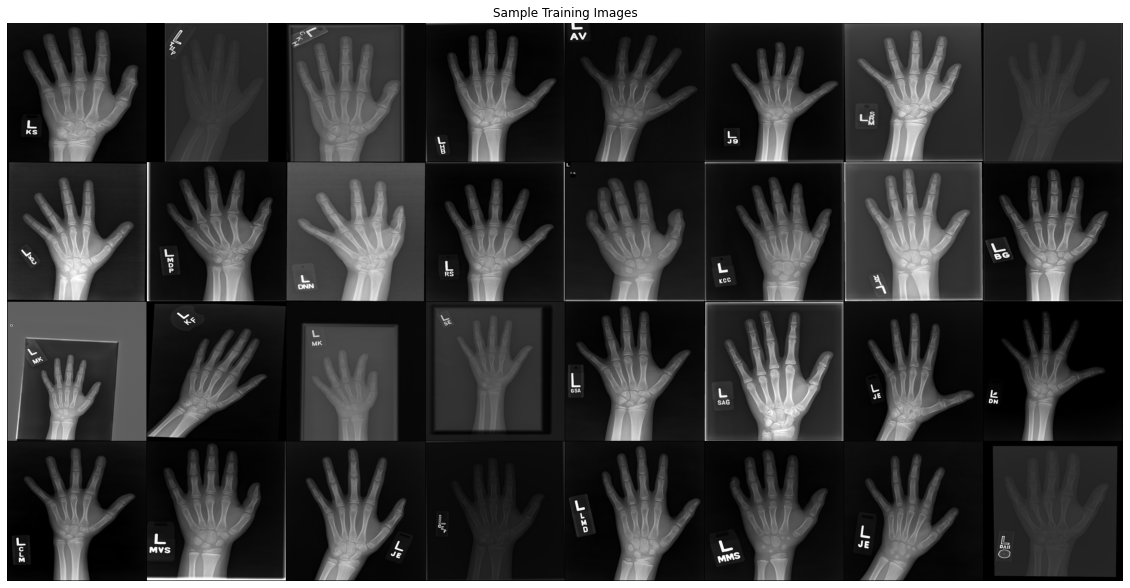

In [15]:
# Plot samples
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, utils

sample_batch = next(iter(trainig_data_loader))
plt.figure(figsize=(20, 20)); plt.axis("off"); plt.title("Sample Training Images")
plt.imshow(np.transpose(utils.make_grid(sample_batch[0], padding=1, normalize=True),(1,2,0)));

In [16]:
model = BoneAgePredictor().double().to(device)
print(model)
optimizer = optim.Adam(model.parameters())
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=2, min_lr=0.0001, verbose=True)

BoneAgePredictor(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (batch3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4609, out_features=68, bias=True)
  (fc2): Linear(in_features=69, out_features=1, bias=True)
)


In [ ]:
train_losses = []
val_losses = []
for epoch in range(20):
        train(model, device, trainig_data_loader, optimizer, epoch)
        train_loss = validation(model, device, trainig_data_loader,'Train')
        val_loss = validation(model, device, validation_data_loader,'Validation')
        scheduler.step(val_loss)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        checkpoint = torch.save({
            'epoch': epoch + 1,
            'train_loss': train_losses,
            'val_loss': val_losses,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        },'model_checkpoint.npy')

Streaming output truncated to the last 5000 lines.
Train Epoch: 4 [4864/10089 (48%)]	Loss: 0.431370
Train Epoch: 4 [4896/10089 (48%)]	Loss: 0.445337
Train Epoch: 4 [4928/10089 (49%)]	Loss: 0.472418
Train Epoch: 4 [4960/10089 (49%)]	Loss: 0.428749
Train Epoch: 4 [4992/10089 (49%)]	Loss: 0.364074
Train Epoch: 4 [5024/10089 (50%)]	Loss: 0.390112
Train Epoch: 4 [5056/10089 (50%)]	Loss: 0.444154
Train Epoch: 4 [5088/10089 (50%)]	Loss: 0.385111
Train Epoch: 4 [5120/10089 (51%)]	Loss: 0.407711
Train Epoch: 4 [5152/10089 (51%)]	Loss: 0.328381
Train Epoch: 4 [5184/10089 (51%)]	Loss: 0.374497
Train Epoch: 4 [5216/10089 (52%)]	Loss: 0.595840
Train Epoch: 4 [5248/10089 (52%)]	Loss: 0.489593
Train Epoch: 4 [5280/10089 (52%)]	Loss: 0.371722
Train Epoch: 4 [5312/10089 (53%)]	Loss: 0.341928
Train Epoch: 4 [5344/10089 (53%)]	Loss: 0.329309
Train Epoch: 4 [5376/10089 (53%)]	Loss: 0.296780
Train Epoch: 4 [5408/10089 (53%)]	Loss: 0.330919
Train Epoch: 4 [5440/10089 (54%)]	Loss: 0.440448
Train Epoch: 4 [54

In [ ]:
checkpoint = torch.load('model_checkpoint.npy')
checkpoint

{'epoch': 20,
 'train_loss': [0.6984679667922912,
  0.5030062751469446,
  0.44945848791145443,
  0.4422206425018285,
  0.39245792275715696,
  0.3237921154087722,
  0.34961304736890036,
  0.36830850293653133,
  0.292581890246209,
  0.26503890294705773,
  0.2749645255471312,
  0.2681956816325979,
  0.23564708191498288,
  0.22375140393040582,
  0.262445446389524,
  0.23323921568169861,
  0.18754956496052516,
  0.19969053051314847,
  0.18683719668541335,
  0.17526283174876003],
 'val_loss': [0.6576806849811587,
  0.4346015611431369,
  0.40077019835307076,
  0.39570633783434156,
  0.3856729106117626,
  0.3372523505841186,
  0.3396496671762269,
  0.40100295160785027,
  0.31587952466367225,
  0.3104413928741367,
  0.31627581116913356,
  0.3307492103897678,
  0.3095515443883002,
  0.30174163333677784,
  0.32839091320253405,
  0.3226991426461016,
  0.2928169754995506,
  0.3129234284423683,
  0.3034097226491226,
  0.3007504473808823],
 'state_dict': OrderedDict([('conv1.weight',
               t

In [ ]:
model.load_state_dict(checkpoint['state_dict'])
model

BoneAgePredictor(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (batch3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4609, out_features=68, bias=True)
  (fc2): Linear(in_features=69, out_features=1, bias=True)
)

In [ ]:
optimizer.load_state_dict(checkpoint['optimizer'])
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.0001
    maximize: False
    weight_decay: 0
)

In [ ]:
epoch = checkpoint['epoch']
epoch

20

In [ ]:
train_loss = checkpoint['train_loss']
train_loss

[0.6984679667922912,
 0.5030062751469446,
 0.44945848791145443,
 0.4422206425018285,
 0.39245792275715696,
 0.3237921154087722,
 0.34961304736890036,
 0.36830850293653133,
 0.292581890246209,
 0.26503890294705773,
 0.2749645255471312,
 0.2681956816325979,
 0.23564708191498288,
 0.22375140393040582,
 0.262445446389524,
 0.23323921568169861,
 0.18754956496052516,
 0.19969053051314847,
 0.18683719668541335,
 0.17526283174876003]

In [ ]:
val_loss = checkpoint['val_loss']
val_loss

[0.6576806849811587,
 0.4346015611431369,
 0.40077019835307076,
 0.39570633783434156,
 0.3856729106117626,
 0.3372523505841186,
 0.3396496671762269,
 0.40100295160785027,
 0.31587952466367225,
 0.3104413928741367,
 0.31627581116913356,
 0.3307492103897678,
 0.3095515443883002,
 0.30174163333677784,
 0.32839091320253405,
 0.3226991426461016,
 0.2928169754995506,
 0.3129234284423683,
 0.3034097226491226,
 0.3007504473808823]

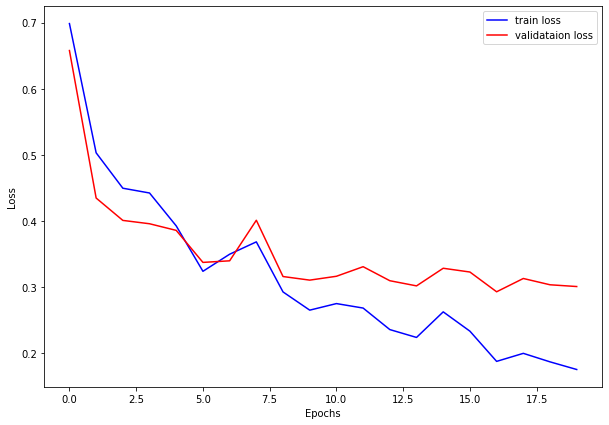

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.plot(train_losses, color='blue', linestyle='-', label='train loss')
plt.plot(val_losses, color='red', linestyle='-', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# check = torch.rand(5,1,256,256)
# model = BoneAgePredictor();
# print(model.forward(check).size())

In [ ]:
# check = pd.read_csv(dataset_path('boneage-training-dataset.csv'));
# print(check)
# print(check['boneage'][0])
# print(check['id'][1])
# check = Image.open(dataset_path('boneage-training-dataset',str(check['id'][1])+'.png')).resize((256,256))
# print(check)
# # check = transform(check)
# # print(check.size())
# # check = torch.from_numpy(np.array(check['boneage'][0]))
# # print(check)

#Grad-CAM


In [17]:
import plotly.io as pio
pio.renderers.default = "png"

In [18]:
import torch
from torchvision import models, transforms
from PIL import Image as PilImage

from omnixai.data.image import Image
from omnixai.explainers.vision.specific.gradcam.pytorch.gradcam import GradCAM

ModuleNotFoundError: ignored